In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ds_toolkit.general_utils.gpu_utils import addGPU

addGPU()

CUDA environment device set to 0


In [3]:
import sys
sys.path.append('../')

In [54]:
from utils.data import CIFAR10_dataset
from utils.misc import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
    show_img_grid,
    show_random_images_for_each_class,
    get_wrong_predictions,
    show_wrong_images
)
from utils.model import Net
from utils.training import train
from utils.testing import test

In [5]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np
import torchvision

import wandb

## Device

In [6]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  True
[INFO] device :  cuda


## Data

In [7]:
train_loader = CIFAR10_dataset(
    train=True, cuda=cuda
).get_loader()
test_loader = CIFAR10_dataset(
    train=False, cuda=cuda
).get_loader()

Files already downloaded and verified
[INFO] train dataset of size 50000 loaded...
Files already downloaded and verified
[INFO] test dataset of size 10000 loaded...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


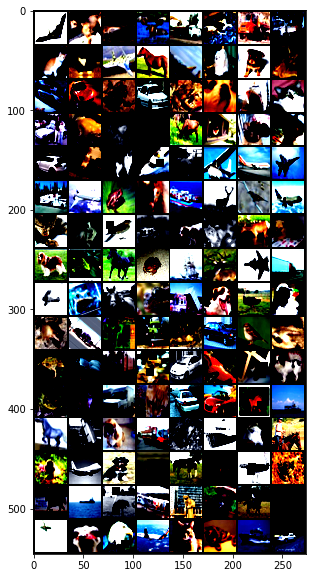

In [8]:
show_random_images(train_loader)

## Training

In [68]:
net = Net().to(device)
show_model_summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
         ConvBNAct-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           4,608
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
           Dropout-9           [-1, 32, 32, 32]               0
        ConvBNAct-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
          Dropout-14           [-1, 32,

In [69]:
EPOCHS = 120
results = {}
models = {}

In [ ]:
run = wandb.init(
    project='cifar_10_lte200k_npool', 
    entity='askmuhsin', 
    reinit=True,
    name="no_sepconv",
    notes="""Remove all Sepconv and replace with normal convs. Total params to 199,096"""
)
results = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
    'epoch': [],
}
optimizer = optim.SGD(
    net.parameters(), 
    lr=0.015, momentum=0.9
)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, 
    patience=3, min_lr=0.0001, verbose=True
)

for epoch in range(0, EPOCHS + 1):
    print(f"[EPOCH {epoch} / {EPOCHS}] -- ")
    train_loss_batch, train_acc_batch = train(
        net, device, 
        train_loader, 
        optimizer, 
        lr_scheduler
    )
    train_acc = np.mean(train_acc_batch)
    train_loss = np.mean(train_loss_batch)
    test_loss, test_acc = test(
        net, device, 
        test_loader,
        lr_scheduler
    )
    wandb.log(
        {
            "train_acc": train_acc,
            "test_acc": test_acc,
            "train_loss": train_loss,
            "test_loss": test_loss,
            "lr": optimizer.param_groups[0]['lr'],
        }
    )
    
    for metric in ['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch']:
        results[metric].append(eval(metric))

run.finish()

wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/391 [00:00<?, ?it/s]

[EPOCH 0 / 120] -- 


Loss=1.3501940965652466 Batch_id=390 Accuracy=33.95: 100%|██████████| 391/391 [00:18<00:00, 21.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.4531, Accuracy: 4724/10000 (47.24%)

[EPOCH 1 / 120] -- 


Loss=1.313488483428955 Batch_id=390 Accuracy=48.73: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2722, Accuracy: 5411/10000 (54.11%)

[EPOCH 2 / 120] -- 


Loss=1.0974290370941162 Batch_id=390 Accuracy=56.32: 100%|██████████| 391/391 [00:16<00:00, 24.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9875, Accuracy: 6423/10000 (64.23%)

[EPOCH 3 / 120] -- 


Loss=1.210845708847046 Batch_id=390 Accuracy=61.43: 100%|██████████| 391/391 [00:16<00:00, 23.14it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9286, Accuracy: 6695/10000 (66.95%)

[EPOCH 4 / 120] -- 


Loss=1.0086485147476196 Batch_id=390 Accuracy=64.76: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8989, Accuracy: 6795/10000 (67.95%)

[EPOCH 5 / 120] -- 


Loss=0.8271805047988892 Batch_id=390 Accuracy=67.31: 100%|██████████| 391/391 [00:17<00:00, 22.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7413, Accuracy: 7385/10000 (73.85%)

[EPOCH 6 / 120] -- 


Loss=0.7436568140983582 Batch_id=300 Accuracy=73.32:  77%|███████▋  | 301/391 [00:13<00:04, 20.77it/s]

In [66]:
run.finish()

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
exp_results_df = pd.DataFrame(results)

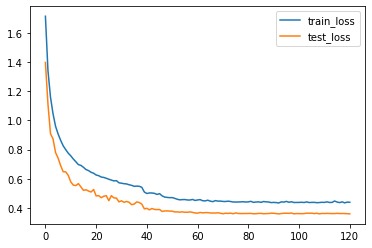

In [48]:
exp_results_df[['train_loss', 'test_loss']].plot()

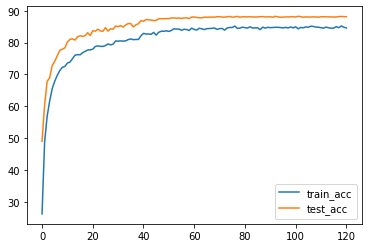

In [49]:
exp_results_df[['train_acc', 'test_acc']].plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Mistakenly predicted as [3, 2, 1, 9, 8, 7, 3, 3, 3, 5, 5, 8, 7, 3, 2, 6, 8, 5, 2, 5]


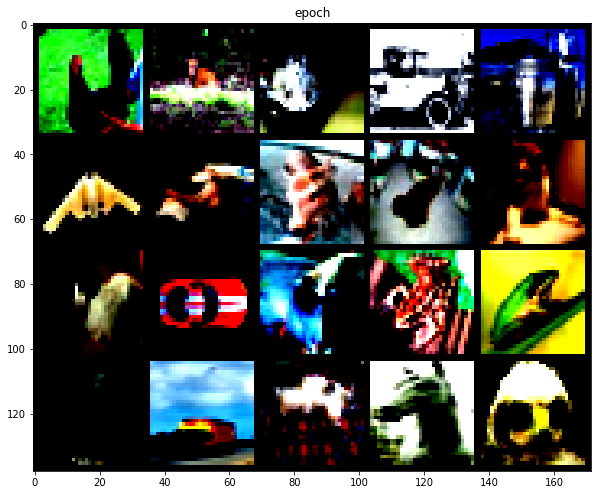

In [55]:
plt.figure(figsize=(10, 10))
targets, predicts, images = get_wrong_predictions(net, test_loader, device)
show_wrong_images(targets, predicts, images)
plt.title(experiment)
plt.show()